Found 20 checkpoint files. Processing...
Finished processing all checkpoints.


C:\Users\batman\AppData\Local\Temp\ipykernel_20184\2330391340.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(y_min - margin, y_max + margin)


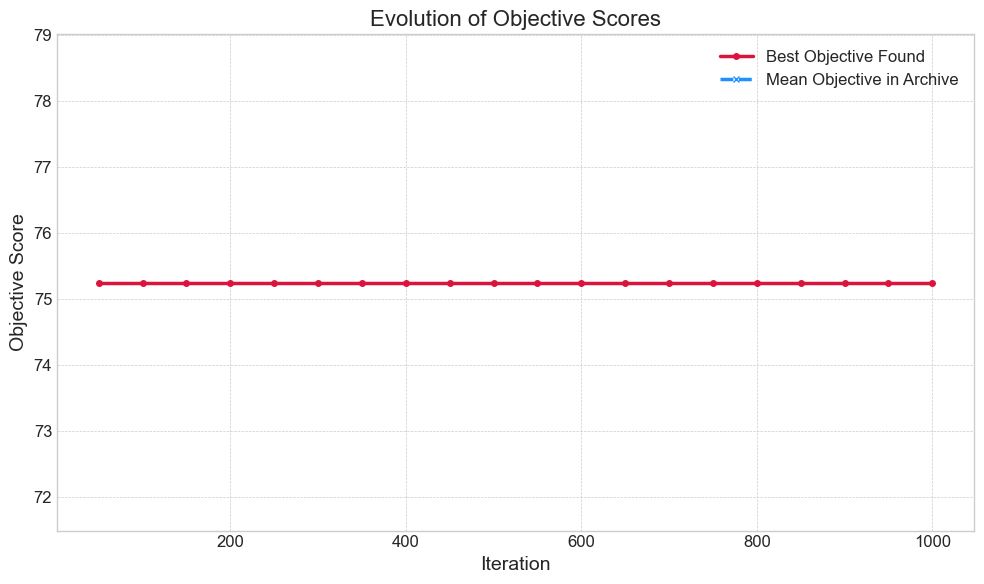

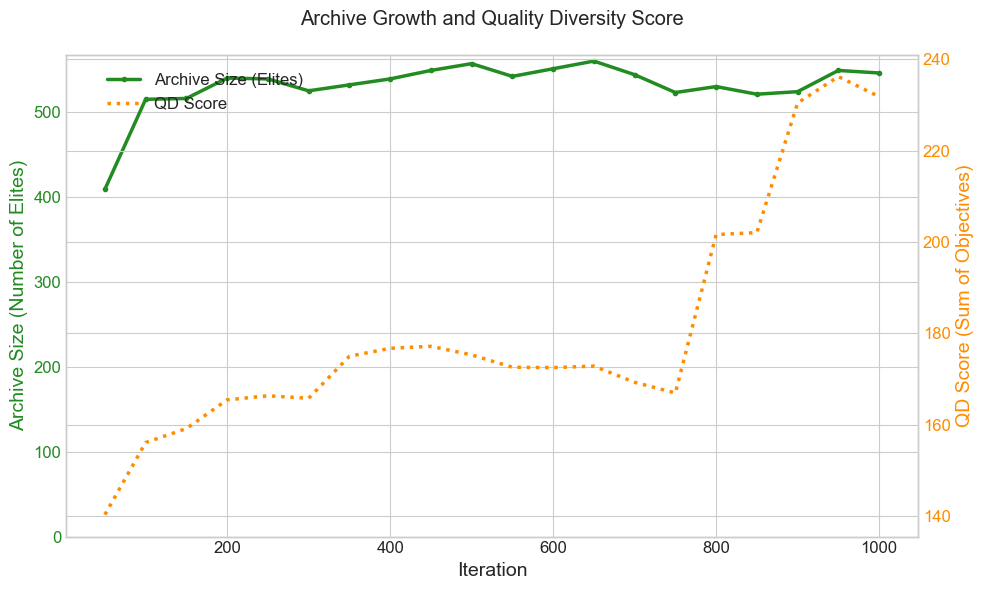

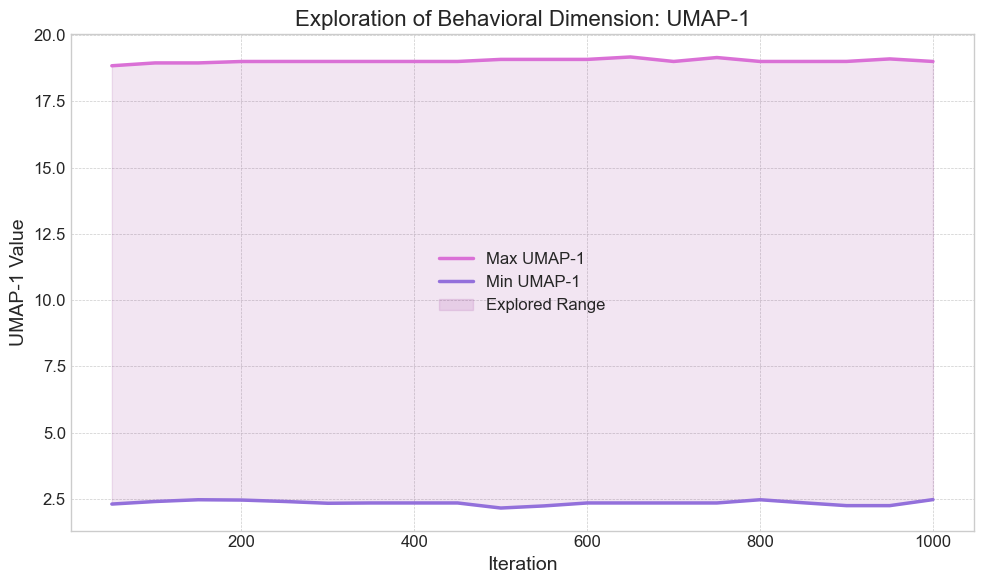

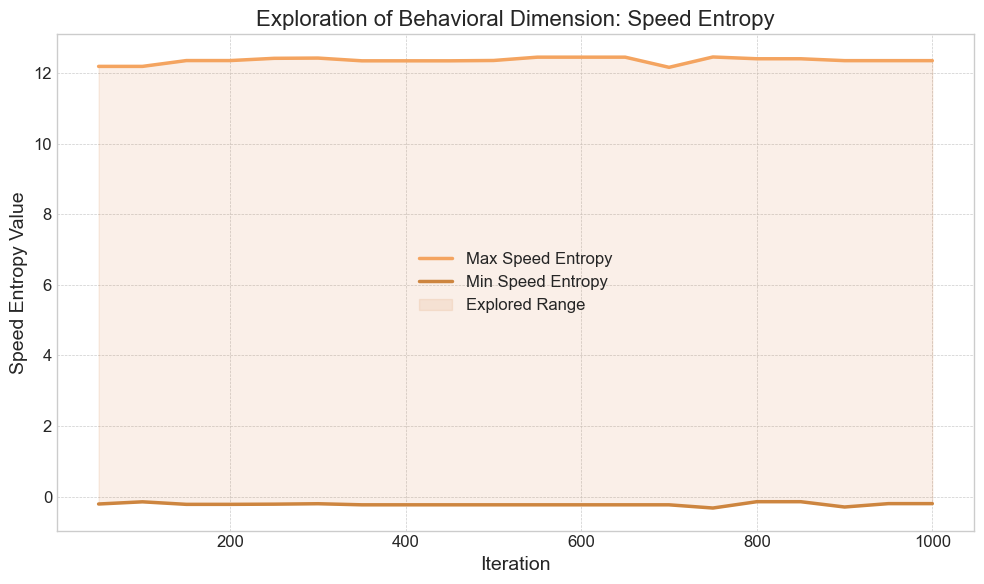


--- Final Archive Summary ---
Total Elites: 546
Best Objective: 75.25
Mean Objective: 0.42
QD Score: 231.79


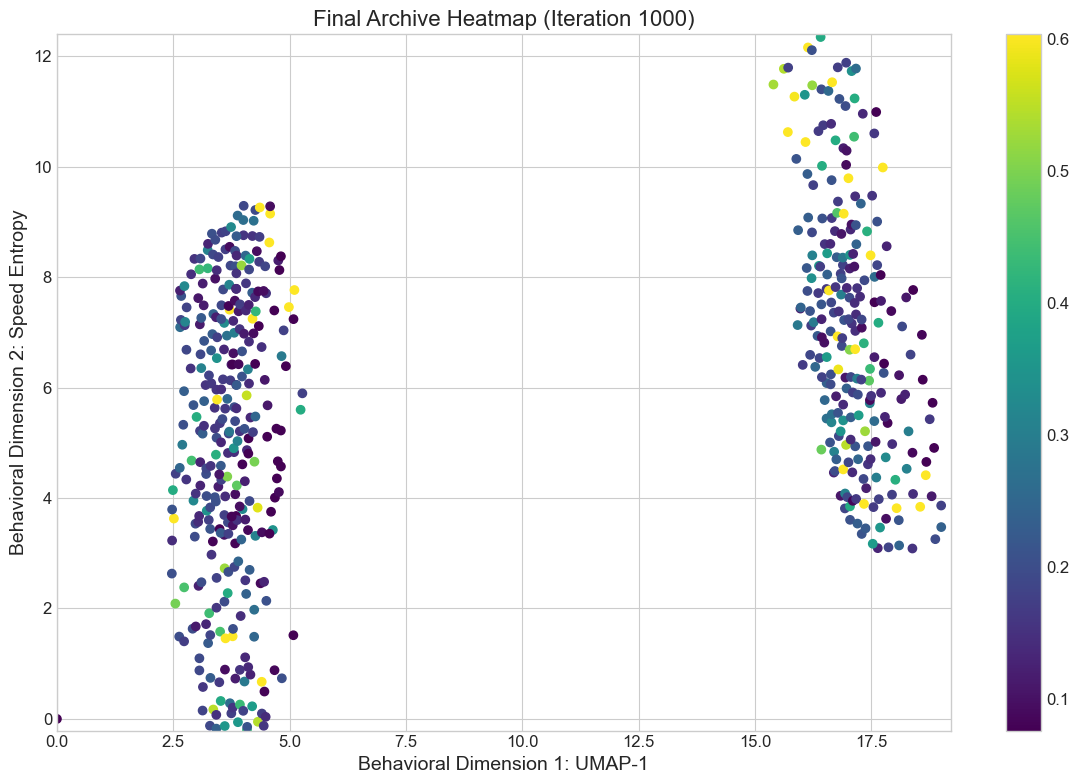


✅ Plot generation complete.


In [6]:
# %%
# =============================================================================
# Imports and Setup
# =============================================================================
import pickle
import glob
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ribs.emitters import EmitterBase
from ribs.visualize import sliding_boundaries_archive_heatmap

# =============================================================================
# Dummy Class to Allow Pickle Loading
# =============================================================================
# This is necessary because the checkpoint file contains an instance of 
# 'CustomEmitter'. Pickle needs the class definition to load the file.
# We don't need its functionality, just its existence.
class CustomEmitter(EmitterBase):
    def __init__(self, archive, solution_dim, **kwargs):
        super().__init__(archive, solution_dim=solution_dim, bounds=None)
    def ask(self): pass
    def tell(self, solution, objective, measures, **kwargs): pass

# =============================================================================
# Configuration
# =============================================================================
INVALID_SCORE = -1e9 
CHECKPOINT_DIR = '.' 

# =============================================================================
# Helper Functions
# =============================================================================
def get_iteration_from_filename(filename):
    """Extracts the iteration number from a checkpoint filename."""
    basename = os.path.basename(filename)
    match = re.search(r'checkpoint_(\d+)\.pkl', basename)
    if match:
        return int(match.group(1))
    return -1

def load_checkpoint_data(directory):
    """
    Loads all checkpoint files and extracts a rich set of statistics for plotting.
    Returns a list of data dictionaries and the final archive object.
    """
    pattern = os.path.join(directory, "checkpoint_*.pkl")
    files = glob.glob(pattern)
    files.sort(key=get_iteration_from_filename)
    
    if not files:
        print(f"Error: No checkpoint files found in '{os.path.abspath(directory)}'")
        return None, None

    print(f"Found {len(files)} checkpoint files. Processing...")
    
    all_data = []
    final_archive = None

    for i, filepath in enumerate(files):
        try:
            with open(filepath, "rb") as f:
                state = pickle.load(f)
        except Exception as e:
            print(f"  - Skipping {os.path.basename(filepath)} due to loading error: {e}")
            continue

        archive = state["scheduler"].archive
        archive_data = archive.data()
        
        # Default values
        stats = {
            "iteration": state["iteration"],
            "global_best_score": state.get("global_best_score", INVALID_SCORE),
            "mean_objective": 0,
            "archive_size": 0,
            "qd_score": 0,
            "umap1_min": np.nan, "umap1_max": np.nan,
            "speed_entropy_min": np.nan, "speed_entropy_max": np.nan,
        }

        if archive_data and 'objective' in archive_data and len(archive_data['objective']) > 0:
            objectives = np.array(archive_data['objective'])
            measures = np.array(archive_data['measures'])
            
            valid_mask = objectives > INVALID_SCORE
            
            if np.any(valid_mask):
                valid_objectives = objectives[valid_mask]
                valid_measures = measures[valid_mask]
                
                stats["archive_size"] = len(valid_objectives)
                stats["mean_objective"] = np.mean(valid_objectives)
                stats["qd_score"] = np.sum(valid_objectives)
                
                # Behavioral descriptor ranges
                stats["umap1_min"], stats["umap1_max"] = np.min(valid_measures[:, 0]), np.max(valid_measures[:, 0])
                stats["speed_entropy_min"], stats["speed_entropy_max"] = np.min(valid_measures[:, 1]), np.max(valid_measures[:, 1])

        all_data.append(stats)
        
        # Store the last successfully loaded archive for the final heatmap
        if i == len(files) - 1:
            final_archive = archive

    print("Finished processing all checkpoints.")
    return all_data, final_archive

def plot_evolution_data(data, final_archive):
    """Generates and displays all plots based on the loaded data."""
    if not data:
        print("No data available to plot.")
        return

    # --- Prepare Data Arrays ---
    iterations = [d["iteration"] for d in data]
    global_best_scores = [d["global_best_score"] for d in data]
    mean_objectives = [d["mean_objective"] for d in data]
    archive_sizes = [d["archive_size"] for d in data]
    qd_scores = [d["qd_score"] for d in data]
    
    umap1_min = [d["umap1_min"] for d in data]
    umap1_max = [d["umap1_max"] for d in data]
    speed_entropy_min = [d["speed_entropy_min"] for d in data]
    speed_entropy_max = [d["speed_entropy_max"] for d in data]
    
    # --- Plotting Style ---
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams.update({
        'figure.figsize': (10, 6), 'lines.linewidth': 2.5, 'font.size': 12,
        'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 12,
        'ytick.labelsize': 12, 'legend.fontsize': 12, 'figure.autolayout': True,
    })

    # === PLOT 1: Objective Scores (with outlier clipping for clarity) ===
    fig1, ax1 = plt.subplots()
    ax1.plot(iterations, global_best_scores, label="Best Objective Found", color='crimson', marker='o', markersize=4, zorder=10)
    ax1.plot(iterations, mean_objectives, label="Mean Objective in Archive", color='dodgerblue', linestyle='--', marker='x', markersize=4)
    
    # Clip y-axis to show the trend more clearly, ignoring extreme outliers
    valid_scores = [s for s in global_best_scores if s > 0]
    if valid_scores:
        y_min = np.percentile(valid_scores, 5)
        y_max = np.percentile(valid_scores, 99)
        margin = (y_max - y_min) * 0.05
        ax1.set_ylim(y_min - margin, y_max + margin)

    ax1.set_title("Evolution of Objective Scores")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Objective Score")
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # === PLOT 2: Archive Size and QD Score (Dual Axis) ===
    fig2, ax2_left = plt.subplots()
    
    # Left axis: Archive Size
    ax2_left.plot(iterations, archive_sizes, label="Archive Size (Elites)", color='forestgreen', marker='.')
    ax2_left.set_xlabel("Iteration")
    ax2_left.set_ylabel("Archive Size (Number of Elites)", color='forestgreen')
    ax2_left.tick_params(axis='y', labelcolor='forestgreen')
    ax2_left.set_ylim(bottom=0)

    # Right axis: QD Score
    ax2_right = ax2_left.twinx()
    ax2_right.plot(iterations, qd_scores, label="QD Score", color='darkorange', linestyle=':')
    ax2_right.set_ylabel("QD Score (Sum of Objectives)", color='darkorange')
    ax2_right.tick_params(axis='y', labelcolor='darkorange')

    fig2.suptitle("Archive Growth and Quality Diversity Score")
    fig2.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.show()

    # === PLOT 3: Behavioral Space Exploration (UMAP-1) ===
    fig3, ax3 = plt.subplots()
    ax3.plot(iterations, umap1_max, color='orchid', label='Max UMAP-1')
    ax3.plot(iterations, umap1_min, color='mediumpurple', label='Min UMAP-1')
    ax3.fill_between(iterations, umap1_min, umap1_max, color='purple', alpha=0.1, label='Explored Range')

    ax3.set_title("Exploration of Behavioral Dimension: UMAP-1")
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("UMAP-1 Value")
    ax3.legend()
    ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # === PLOT 4: Behavioral Space Exploration (Speed Entropy) ===
    fig4, ax4 = plt.subplots()
    ax4.plot(iterations, speed_entropy_max, color='sandybrown', label='Max Speed Entropy')
    ax4.plot(iterations, speed_entropy_min, color='peru', label='Min Speed Entropy')
    ax4.fill_between(iterations, speed_entropy_min, speed_entropy_max, color='chocolate', alpha=0.1, label='Explored Range')

    ax4.set_title("Exploration of Behavioral Dimension: Speed Entropy")
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Speed Entropy Value")
    ax4.legend()
    ax4.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # === PLOT 5: Final Archive Heatmap ===
    if final_archive:
        print("\n--- Final Archive Summary ---")
        final_data = final_archive.data()
        final_objs = np.array(final_data['objective'])
        valid_final_objs = final_objs[final_objs > INVALID_SCORE]
        
        print(f"Total Elites: {len(valid_final_objs)}")
        if len(valid_final_objs) > 0:
            print(f"Best Objective: {np.max(valid_final_objs):.2f}")
            print(f"Mean Objective: {np.mean(valid_final_objs):.2f}")
            print(f"QD Score: {np.sum(valid_final_objs):.2f}")

            # Clip color bar for better visualization
            vmin, vmax = np.percentile(valid_final_objs, [5, 95])
            
            fig5, ax5 = plt.subplots(figsize=(12, 8))
            sliding_boundaries_archive_heatmap(final_archive, ax=ax5, vmin=vmin, vmax=vmax, cmap='viridis')
            ax5.set_title(f"Final Archive Heatmap (Iteration {iterations[-1]})")
            ax5.set_xlabel("Behavioral Dimension 1: UMAP-1")
            ax5.set_ylabel("Behavioral Dimension 2: Speed Entropy")
            plt.show()
    else:
        print("Could not generate final heatmap because no archive was loaded.")

# =============================================================================
# Main Execution Block
# =============================================================================
all_checkpoint_data, final_archive_obj = load_checkpoint_data(CHECKPOINT_DIR)

if all_checkpoint_data:
    plot_evolution_data(all_checkpoint_data, final_archive_obj)
    print("\n✅ Plot generation complete.")